#Hw4 Gabriel West
##Linear Model Selection and Regularization
For this homework, I will be investigating a number of different methods for selection/regularization of linear models. I will use subset selection, shrinkage, and dimensional reduction methods. A brief comparison of these methods is presented below.

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
require(MASS)
require(ISLR)

Loading required package: MASS
Loading required package: ISLR


In [4]:
%%R
auto.nn <- Auto
# Make origin a factor and remove the name predictor
auto.nn$origin2 <- ifelse(Auto$origin == 2, 1, 0)
auto.nn$origin3 <- ifelse(Auto$origin == 3, 1, 0)

auto.nn <- subset(auto.nn, select=-c(name, origin))

##Preamble

In [281]:
%%R
# Define useful functions
k.folds <- function(data, k=10){
    sample(1:k, nrow(data), replace=TRUE) 
}

k.folds.errs <- function(data, func, k=10, m=8, ...){
    folds <- k.folds(data=data, k=k)
    errs <- matrix(NA, k, m)
    for (i in 1:k){
#         Split into k folds
        train <- data[folds != i,]
        test <- data[folds == i,]
#         get errors for this k using any function that obeys this call signature and returns a vector of length m
        e <- func(train=train, test=test, m=m, ...)
        errs[i,] <- e
    }
#     Return a vector of the errors averaged over all k folds
    return(apply(errs, 2, mean))
}

##Subset Selection

In [279]:
%%R

subs.select <- function(X, train, test, m, ...){
    require(leaps)
    require(boot)
    response.var <- all.vars(X[[2]])
    regfit.full <- regsubsets(X, data=train, nvmax=m, ...)
    summary.reg <- summary(regfit.full)
#         Get the coef names minus intercept
    predictors <- regfit.full$xnames[-1]
    errs <- rep(NA, m)
    for (j in 1:m){
#             Get the list of predictors used in this subset (ignoring intercept)
        preds <- predictors[summary.reg$which[j, -1]]
#             Generate a linear formula for this model
        form <- as.formula(paste(response.var, paste(preds, collapse="+"), sep=" ~ "))
#             recreate the fit (because regsubsets doesn't actually make the fit)
        fit <- glm(form, data=train)
        pr <- predict(fit, newdata=test)
#             errs[i, j] is the mean squared error for the p=j predictor model, for fold i
        mse <- mean((test[response.var] - pr)^2)
        errs[j] <- mse
    }
    return(errs)
}

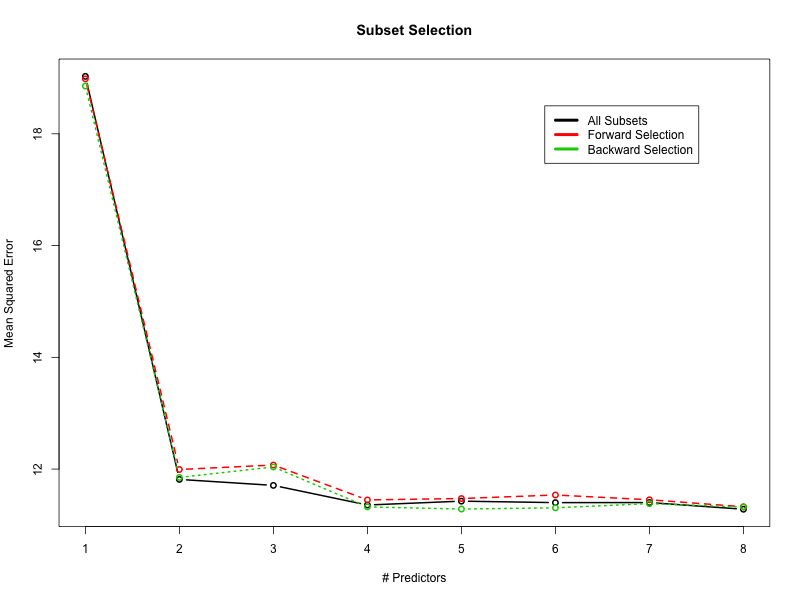

In [292]:
%%R -w 800 -h 600 -u px
# set.seed(1)
errs <- k.folds.errs(X=mpg~., data=auto.nn, func=subs.select)
errs2 <- k.folds.errs(X=mpg~., data=auto.nn, func=subs.select, method='forward')
errs3 <- k.folds.errs(X=mpg~., data=auto.nn, func=subs.select, method='backward')

dat <- matrix(c(errs, errs2, errs3), ncol=3, nrow=8)

matplot(dat,  type=c('b'), col=1:3, xlab="# Predictors", ylab="Mean Squared Error", main="Subset Selection", pch=1, lwd=2)
legend("topright", legend=c("All Subsets", "Forward Selection", "Backward Selection"), col=1:3, lwd=4, inset=0.1)

It looks like the "best" model is the one with all 8 predictors, though to avoid overfitting, and to improve interpretability and parsimony, we may select the 4 predictor model.

[1] "The MSE for the best subset selection model is: 11.323456"


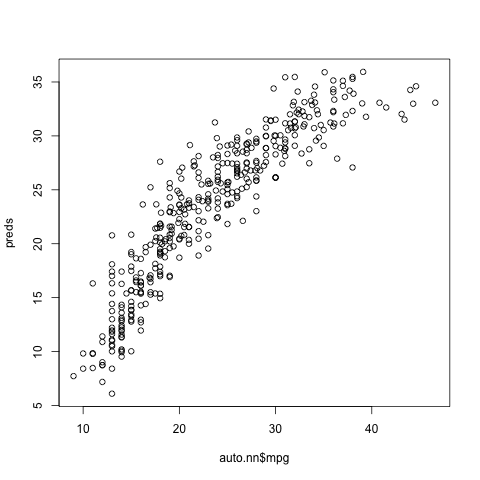

In [359]:
%%R
best.fit <- regsubsets(mpg~., data=auto.nn)
coefi <- coef(best.fit, 4)
xvars <- names(coefi)
f <- glm(mpg ~ weight + year + origin2 + origin3, data=auto.nn)
preds <- predict(f, auto.nn)
plot(auto.nn$mpg, preds)
print(sprintf("The MSE for the best subset selection model is: %f", min(c(errs[4], errs2[4], errs3[4]))))

##Ridge Regression and the Lasso

###Ridge Regression

In [322]:
%%R
test <- sample(1:nrow(auto.nn), nrow(auto.nn)/2)
train <- (-test)

[1] "The lambda that gives lowest MSE is 0.694061"


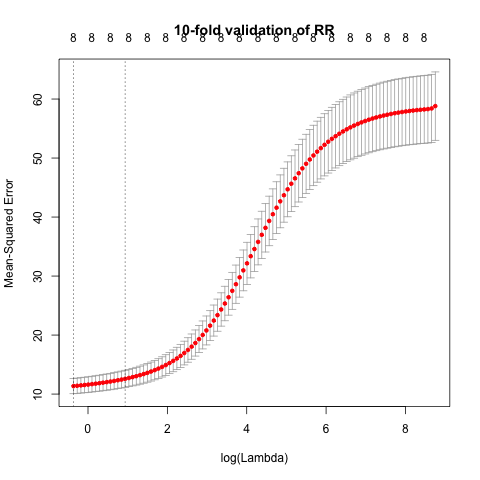

In [323]:
%%R
library(glmnet)
set.seed(1)
auto.nn <- na.omit(auto.nn)
x <- model.matrix(mpg ~., data=auto.nn)[, -1]
y <- auto.nn$mpg
cv.out <- cv.glmnet(x[train,], y[train], alpha=0)
plot(cv.out, main="10-fold validation of RR")
best.lambda <- cv.out$lambda.min
print(sprintf("The lambda that gives lowest MSE is %f", best.lambda)) 

In [357]:
%%R
grid <- 10^seq(10, -2, length=100)
ridge.mod <- glmnet(x[train,], y[train], alpha=0, lambda=grid)
ridge.pred <- predict(ridge.mod, s=best.lambda, newx=x[test,])
ridge.best.mse <- mean((ridge.pred - y[test])^2)
print(sprintf("The MSE for the best RR model is: %f", ridge.best.mse))

[1] "The MSE for the best RR model is: 12.245494"


###Lasso

[1] "The lambda that gives lowest MSE is 0.004577"


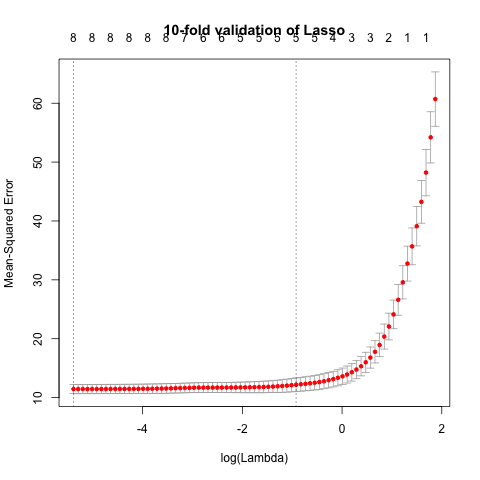

In [318]:
%%R
set.seed(1)
cv.out <- cv.glmnet(x[train,], y[train], alpha=1)
best.lambda <- cv.out$lambda.min
plot(cv.out, main="10-fold validation of Lasso")
print(sprintf("The lambda that gives lowest MSE is %f", best.lambda)) 

In [355]:
%%R
lasso.mod <- glmnet(x[train,], y[train], alpha=1, lambda=grid)
lasso.pred <- predict(lasso.mod, s=best.lambda, newx=x[test,])
lasso.best.mse <- mean((lasso.pred - y[test])^2)
print(sprintf("The MSE for the best Lasso model is: %f", lasso.best.mse))

[1] "The MSE for the best Lasso model is: 12.840643"


##PC Regression and PLS Regression
###Principal Components Regression

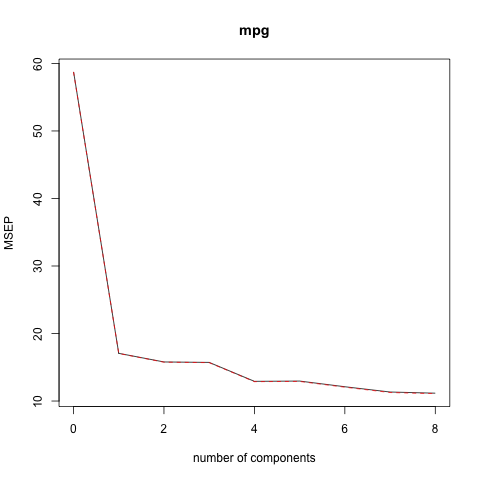

In [335]:
%%R
library(pls)
set.seed(1)
pcr.fit <- pcr(mpg~., data=auto.nn, subset=train, scale=TRUE, validation="CV")
validationplot(pcr.fit, val.type="MSEP")

This shows that the least squares solution may be best, considering that the 10-fold MSE error is smallest when no dimensional reduction is done (ncomp=8). However, ncomp=7 is nearly as good, so we can try to use that to see what sort of prediction error we get.

In [354]:
%%R
pcr.pred <- predict(pcr.fit, x[test,], ncomp=7)
pcr.best.mse <- mean((pcr.pred - y[test])^2)
print(sprintf("The MSE for the 'best' PCR model is: %f", pcr.best.mse))

[1] "The MSE for the 'best' PCR model is: 12.068974"


###PLS Regression

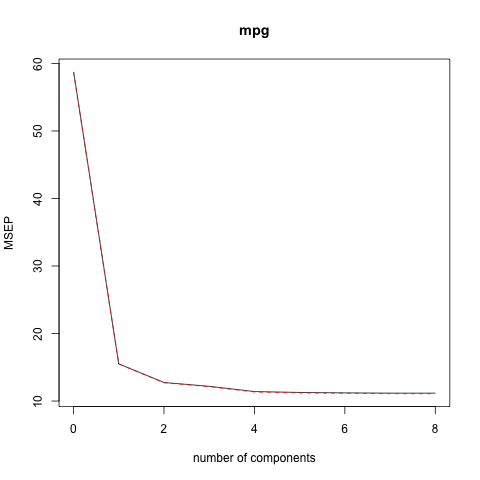

In [349]:
%%R
set.seed(1)
pls.fit <- plsr(mpg~., data=auto.nn, subset=train, scale=TRUE, validation="CV")
validationplot(pls.fit, val.type="MSEP")

Again we see that the MSE is lowest with 8 components, but the 4 component model is nearly as good, with significant reductions.

In [353]:
%%R
pls.pred <- predict(pls.fit, x[test,], ncomp=4)
pls.best.mse <- mean((pls.pred - y[test])^2)
print(sprintf("The MSE for the 'best' PLS model is: %f", pls.best.mse))

[1] "The MSE for the 'best' PLS model is: 12.300736"


##Conclusion
Based on this brief exploration, it is not unreasonable to assume that subset selection performs best in terms of 10-fold MSE. As an exhaustive search, however, it is not always a tractable solution. Interestingly, we saw that forward and backward selection performed nearly as well for this data set. These algorithms are much more tractable than all subsets, and show promise for a larger number of predictor variables.

Ridge regression and Lasso appear to have 10-fold MSE results comparable to the subset selection algorithms, though in the case of Ridge Regression, we are still not reducing the number of predictor variables (which could lead to problems with large datasets). Lasso does slightly worse, but the reduction to the problem space may be worth it.

Dimensional reduction performs well, and can significantly reduce the complexity of the model. This comes at the cost of interpretability, as PCR and PLSR models are not directly interpretable. For this dataset, PCR did not seem to do any better than the least squares solution, and the tradeoff may not be worth it. PLSR did manage to bring significant reductions and out-performed the Lasso.

Each technique has a clearly defined use-case, and it is important to realize when each is appropriate.